# 02 A - Similarity Search Methods Comparison

This notebook compares different similarity search methods for RAG:
- Cosine Similarity
- Euclidean Distance  
- Dot Product
- Manhattan Distance
- Jaccard Similarity (for comparison)

We'll evaluate retrieval accuracy, computational speed, and use cases.

In [1]:
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import (
    cosine_similarity, 
    euclidean_distances, 
    manhattan_distances
)
from scipy.spatial.distance import jaccard
from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()
client = OpenAI()

print("Libraries loaded successfully")

Libraries loaded successfully


In [2]:
# Load embedding results from previous notebook
try:
    with open(r'C:\Users\Admin\Desktop\para-expe\data\rag_embeddings.pkl', 'rb') as f:
        data = pickle.load(f)
    
    chunks = data['chunks']
    embedding_results = data['embedding_results']
    test_queries = data['test_queries']
    
    print(f"Loaded {len(chunks)} chunks")
    print(f"Available embedding models: {list(embedding_results.keys())}")
    print(f"Test queries: {len(test_queries)}")
    
except FileNotFoundError:
    print("Please run notebook 00_embedding_models_comparison.ipynb first")
    raise

Loaded 82 chunks
Available embedding models: ['text-embedding-3-small', 'text-embedding-3-large', 'text-embedding-ada-002']
Test queries: 8


In [3]:
# Use the best performing embedding model from previous analysis
# (typically text-embedding-3-small for balance of performance and cost)
SELECTED_MODEL = 'text-embedding-3-small'
embeddings = np.array(embedding_results[SELECTED_MODEL]['embeddings'])

print(f"Using {SELECTED_MODEL}")
print(f"Embeddings shape: {embeddings.shape}")
print(f"Vector dimensions: {embeddings.shape[1]}")

Using text-embedding-3-small
Embeddings shape: (82, 1536)
Vector dimensions: 1536


In [4]:
# Similarity search methods
class SimilaritySearcher:
    def __init__(self, embeddings):
        self.embeddings = embeddings
        self.n_docs = len(embeddings)
    
    def cosine_search(self, query_embedding, k=5):
        """Cosine similarity: measures angle between vectors"""
        similarities = cosine_similarity([query_embedding], self.embeddings)[0]
        top_indices = np.argsort(similarities)[::-1][:k]
        return top_indices, similarities[top_indices]
    
    def euclidean_search(self, query_embedding, k=5):
        """Euclidean distance: L2 norm (convert to similarity)"""
        distances = euclidean_distances([query_embedding], self.embeddings)[0]
        # Convert distance to similarity (smaller distance = higher similarity)
        similarities = 1 / (1 + distances)
        top_indices = np.argsort(similarities)[::-1][:k]
        return top_indices, similarities[top_indices]
    
    def manhattan_search(self, query_embedding, k=5):
        """Manhattan distance: L1 norm (convert to similarity)"""
        distances = manhattan_distances([query_embedding], self.embeddings)[0]
        similarities = 1 / (1 + distances)
        top_indices = np.argsort(similarities)[::-1][:k]
        return top_indices, similarities[top_indices]
    
    def dot_product_search(self, query_embedding, k=5):
        """Dot product: assumes normalized vectors"""
        # Normalize vectors for fair comparison
        query_norm = query_embedding / np.linalg.norm(query_embedding)
        embeddings_norm = self.embeddings / np.linalg.norm(self.embeddings, axis=1, keepdims=True)
        
        similarities = np.dot(embeddings_norm, query_norm)
        top_indices = np.argsort(similarities)[::-1][:k]
        return top_indices, similarities[top_indices]
    
    def minkowski_search(self, query_embedding, k=5, p=3):
        """Minkowski distance with parameter p"""
        distances = np.array([
            np.sum(np.abs(query_embedding - emb) ** p) ** (1/p) 
            for emb in self.embeddings
        ])
        similarities = 1 / (1 + distances)
        top_indices = np.argsort(similarities)[::-1][:k]
        return top_indices, similarities[top_indices]

searcher = SimilaritySearcher(embeddings)
print("Similarity searcher initialized")

Similarity searcher initialized


In [5]:
# Define search methods to compare
SEARCH_METHODS = {
    'cosine': searcher.cosine_search,
    'euclidean': searcher.euclidean_search,
    'manhattan': searcher.manhattan_search,
    'dot_product': searcher.dot_product_search,
    'minkowski_p3': searcher.minkowski_search
}

print(f"Testing {len(SEARCH_METHODS)} similarity methods:")
for method in SEARCH_METHODS.keys():
    print(f"  • {method}")

Testing 5 similarity methods:
  • cosine
  • euclidean
  • manhattan
  • dot_product
  • minkowski_p3


In [6]:
# Function to get query embedding
def get_query_embedding(query, model=SELECTED_MODEL):
    response = client.embeddings.create(
        input=[query.replace("\n", " ")],
        model=model
    )
    return np.array(response.data[0].embedding)

print("Query embedding function ready")

Query embedding function ready


In [7]:
# Comprehensive evaluation of all similarity methods
evaluation_results = []
speed_results = []

print("Starting comprehensive evaluation...\n")

for query_idx, query in enumerate(test_queries):
    print(f"Query {query_idx + 1}/{len(test_queries)}: {query[:50]}...")
    
    # Get query embedding
    query_embedding = get_query_embedding(query)
    
    for method_name, method_func in SEARCH_METHODS.items():
        # Measure speed
        start_time = time.time()
        top_indices, similarities = method_func(query_embedding, k=5)
        search_time = time.time() - start_time
        
        # Store results
        evaluation_results.append({
            'query': query,
            'query_idx': query_idx,
            'method': method_name,
            'top_indices': top_indices.tolist(),
            'similarities': similarities.tolist(),
            'mean_similarity': np.mean(similarities),
            'max_similarity': np.max(similarities),
            'min_similarity': np.min(similarities),
            'search_time_ms': search_time * 1000
        })
        
        speed_results.append({
            'method': method_name,
            'search_time_ms': search_time * 1000
        })
    
    time.sleep(0.1)  # Rate limiting for API calls

results_df = pd.DataFrame(evaluation_results)
speed_df = pd.DataFrame(speed_results)

print(f"\nCompleted evaluation: {len(evaluation_results)} tests")

Starting comprehensive evaluation...

Query 1/8: What are the key capabilities of Gemini models?...
Query 2/8: How does Gemini compare to other multimodal models...
Query 3/8: What are the different versions of Gemini?...
Query 4/8: What training data was used for Gemini?...
Query 5/8: What are the safety measures in Gemini models?...
Query 6/8: How does Gemini perform on benchmarks?...
Query 7/8: What is the architecture of Gemini?...
Query 8/8: What are the limitations of Gemini?...

Completed evaluation: 40 tests


In [8]:
# Analyze retrieval overlap between methods
def calculate_overlap(indices1, indices2):
    """Calculate Jaccard similarity between two sets of indices"""
    set1, set2 = set(indices1), set(indices2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

# Calculate pairwise overlaps for each query
overlap_results = []
methods = list(SEARCH_METHODS.keys())

for query_idx in range(len(test_queries)):
    query_results = results_df[results_df['query_idx'] == query_idx]
    
    for i, method1 in enumerate(methods):
        for j, method2 in enumerate(methods):
            if i <= j:  # Avoid duplicates
                indices1 = query_results[query_results['method'] == method1]['top_indices'].iloc[0]
                indices2 = query_results[query_results['method'] == method2]['top_indices'].iloc[0]
                
                overlap = calculate_overlap(indices1, indices2)
                
                overlap_results.append({
                    'query_idx': query_idx,
                    'method1': method1,
                    'method2': method2,
                    'overlap': overlap
                })

overlap_df = pd.DataFrame(overlap_results)
print("Overlap analysis completed")

Overlap analysis completed


In [9]:
# Create comprehensive comparison summary
method_summary = []

for method in methods:
    method_data = results_df[results_df['method'] == method]
    speed_data = speed_df[speed_df['method'] == method]
    
    method_summary.append({
        'Method': method.replace('_', ' ').title(),
        'Avg Similarity': f"{method_data['mean_similarity'].mean():.4f}",
        'Max Similarity': f"{method_data['max_similarity'].mean():.4f}",
        'Similarity Std': f"{method_data['mean_similarity'].std():.4f}",
        'Avg Speed (ms)': f"{speed_data['search_time_ms'].mean():.2f}",
        'Speed Std (ms)': f"{speed_data['search_time_ms'].std():.2f}"
    })

summary_df = pd.DataFrame(method_summary)
print("\n=== SIMILARITY METHODS COMPARISON ===")
print(summary_df.to_string(index=False))


=== SIMILARITY METHODS COMPARISON ===
      Method Avg Similarity Max Similarity Similarity Std Avg Speed (ms) Speed Std (ms)
      Cosine         0.6406         0.6696         0.0455           1.68           1.81
   Euclidean         0.5422         0.5524         0.0163           0.60           0.27
   Manhattan         0.0370         0.0384         0.0023           0.45           0.23
 Dot Product         0.6406         0.6696         0.0455           0.40           0.37
Minkowski P3         0.7729         0.7799         0.0116           4.98           0.49


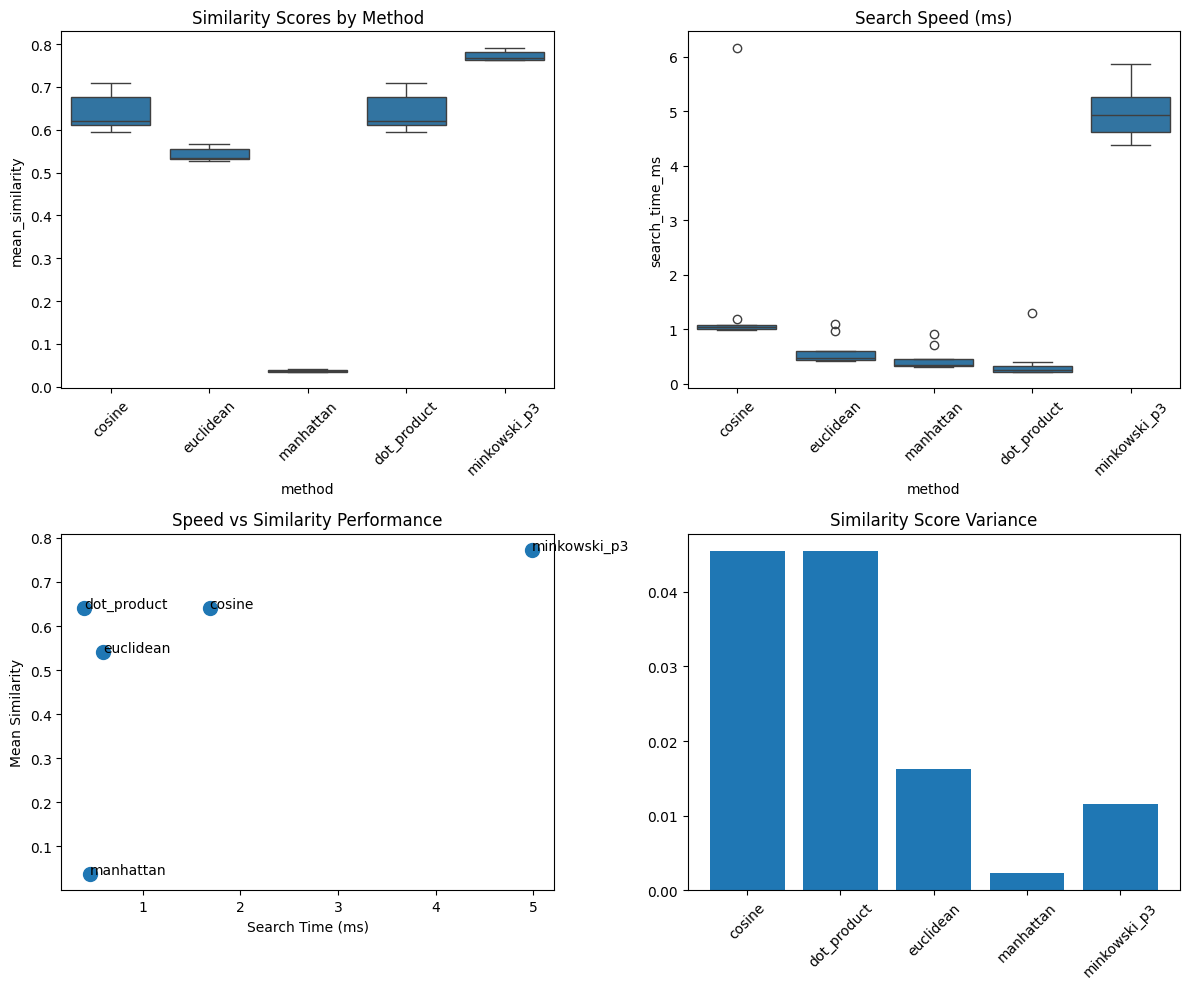

In [10]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Similarity scores distribution
sns.boxplot(data=results_df, x='method', y='mean_similarity', ax=axes[0,0])
axes[0,0].set_title('Similarity Scores by Method')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Search speed comparison
sns.boxplot(data=speed_df, x='method', y='search_time_ms', ax=axes[0,1])
axes[0,1].set_title('Search Speed (ms)')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Speed vs Similarity scatter
method_stats = results_df.groupby('method').agg({
    'mean_similarity': 'mean',
    'search_time_ms': 'mean'
}).reset_index()

axes[1,0].scatter(method_stats['search_time_ms'], method_stats['mean_similarity'], s=100)
for _, row in method_stats.iterrows():
    axes[1,0].annotate(row['method'], (row['search_time_ms'], row['mean_similarity']))
axes[1,0].set_xlabel('Search Time (ms)')
axes[1,0].set_ylabel('Mean Similarity')
axes[1,0].set_title('Speed vs Similarity Performance')

# 4. Similarity variance by method
similarity_variance = results_df.groupby('method')['mean_similarity'].std()
axes[1,1].bar(similarity_variance.index, similarity_variance.values)
axes[1,1].set_title('Similarity Score Variance')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [11]:
# Detailed analysis of method characteristics
print("\n=== DETAILED METHOD ANALYSIS ===")

print("\n1. COSINE SIMILARITY:")
print("   • Measures angle between vectors (direction)")
print("   • Range: [-1, 1], higher is more similar")
print("   • Invariant to vector magnitude")
print("   • Best for: High-dimensional sparse data, text embeddings")

print("\n2. EUCLIDEAN DISTANCE:")
print("   • Measures straight-line distance (L2 norm)")
print("   • Sensitive to vector magnitude and dimensionality")
print("   • Best for: Low-dimensional dense data, when magnitude matters")

print("\n3. MANHATTAN DISTANCE:")
print("   • Sum of absolute differences (L1 norm)")
print("   • Less sensitive to outliers than Euclidean")
print("   • Best for: High-dimensional data, robust to noise")

print("\n4. DOT PRODUCT:")
print("   • Measures both angle and magnitude")
print("   • Equivalent to cosine when vectors are normalized")
print("   • Best for: When both direction and magnitude matter")

print("\n5. MINKOWSKI (p=3):")
print("   • Generalization of Euclidean (p=2) and Manhattan (p=1)")
print("   • Higher p values emphasize larger differences")
print("   • Best for: Specialized applications, outlier emphasis")


=== DETAILED METHOD ANALYSIS ===

1. COSINE SIMILARITY:
   • Measures angle between vectors (direction)
   • Range: [-1, 1], higher is more similar
   • Invariant to vector magnitude
   • Best for: High-dimensional sparse data, text embeddings

2. EUCLIDEAN DISTANCE:
   • Measures straight-line distance (L2 norm)
   • Sensitive to vector magnitude and dimensionality
   • Best for: Low-dimensional dense data, when magnitude matters

3. MANHATTAN DISTANCE:
   • Sum of absolute differences (L1 norm)
   • Less sensitive to outliers than Euclidean
   • Best for: High-dimensional data, robust to noise

4. DOT PRODUCT:
   • Measures both angle and magnitude
   • Equivalent to cosine when vectors are normalized
   • Best for: When both direction and magnitude matter

5. MINKOWSKI (p=3):
   • Generalization of Euclidean (p=2) and Manhattan (p=1)
   • Higher p values emphasize larger differences
   • Best for: Specialized applications, outlier emphasis


In [12]:
# Performance ranking and recommendations
print("\n=== PERFORMANCE RANKING ===")

# Rank by average similarity score
similarity_ranking = results_df.groupby('method')['mean_similarity'].mean().sort_values(ascending=False)
print("\nBy Retrieval Quality (Mean Similarity):")
for i, (method, score) in enumerate(similarity_ranking.items(), 1):
    print(f"   {i}. {method}: {score:.4f}")

# Rank by speed
speed_ranking = speed_df.groupby('method')['search_time_ms'].mean().sort_values()
print("\nBy Speed (Lower is Better):")
for i, (method, time_ms) in enumerate(speed_ranking.items(), 1):
    print(f"   {i}. {method}: {time_ms:.2f}ms")

# Combined score (normalize and combine)
similarity_norm = (similarity_ranking - similarity_ranking.min()) / (similarity_ranking.max() - similarity_ranking.min())
speed_norm = 1 - ((speed_ranking - speed_ranking.min()) / (speed_ranking.max() - speed_ranking.min()))

combined_score = (similarity_norm + speed_norm) / 2
combined_ranking = combined_score.sort_values(ascending=False)

print("\nBy Combined Score (Quality + Speed):")
for i, (method, score) in enumerate(combined_ranking.items(), 1):
    print(f"   {i}. {method}: {score:.3f}")


=== PERFORMANCE RANKING ===

By Retrieval Quality (Mean Similarity):
   1. minkowski_p3: 0.7729
   2. dot_product: 0.6406
   3. cosine: 0.6406
   4. euclidean: 0.5422
   5. manhattan: 0.0370

By Speed (Lower is Better):
   1. dot_product: 0.40ms
   2. manhattan: 0.45ms
   3. euclidean: 0.60ms
   4. cosine: 1.68ms
   5. minkowski_p3: 4.98ms

By Combined Score (Quality + Speed):
   1. dot_product: 0.910
   2. euclidean: 0.821
   3. cosine: 0.770
   4. minkowski_p3: 0.500
   5. manhattan: 0.494


In [13]:
# Save results for next notebooks
similarity_results = {
    'chunks': chunks,
    'embeddings': embeddings,
    'selected_model': SELECTED_MODEL,
    'evaluation_results': results_df,
    'speed_results': speed_df,
    'overlap_results': overlap_df,
    'method_summary': summary_df,
    'similarity_ranking': similarity_ranking,
    'speed_ranking': speed_ranking,
    'combined_ranking': combined_ranking,
    'test_queries': test_queries
}

with open(r'C:\Users\Admin\Desktop\para-expe\data\similarity_methods_comparison.pkl', 'wb') as f:
    pickle.dump(similarity_results, f)

print("Results saved to ../data/similarity_methods_comparison.pkl")

Results saved to ../data/similarity_methods_comparison.pkl


In [14]:
# Final recommendations
print("\n=== FINAL RECOMMENDATIONS ===")

best_overall = combined_ranking.index[0]
best_quality = similarity_ranking.index[0]
best_speed = speed_ranking.index[0]

print(f"\n🏆 BEST OVERALL: {best_overall}")
print(f"   • Balanced performance and speed")
print(f"   • Recommended for most RAG applications")

print(f"\n🎯 BEST QUALITY: {best_quality}")
print(f"   • Highest retrieval accuracy")
print(f"   • Use when accuracy is critical")

print(f"\n⚡ FASTEST: {best_speed}")
print(f"   • Lowest latency")
print(f"   • Use for real-time applications")

print("\n📋 USE CASE GUIDE:")
print("   • Text embeddings (standard): Cosine Similarity")
print("   • Real-time search: Dot Product (if normalized)")
print("   • Noisy data: Manhattan Distance")
print("   • Magnitude matters: Euclidean Distance")
print("   • Outlier emphasis: Minkowski (p>2)")

print("\n✅ For most RAG applications, COSINE SIMILARITY is recommended")
print("   due to its effectiveness with high-dimensional text embeddings.")


=== FINAL RECOMMENDATIONS ===

🏆 BEST OVERALL: dot_product
   • Balanced performance and speed
   • Recommended for most RAG applications

🎯 BEST QUALITY: minkowski_p3
   • Highest retrieval accuracy
   • Use when accuracy is critical

⚡ FASTEST: dot_product
   • Lowest latency
   • Use for real-time applications

📋 USE CASE GUIDE:
   • Text embeddings (standard): Cosine Similarity
   • Real-time search: Dot Product (if normalized)
   • Noisy data: Manhattan Distance
   • Magnitude matters: Euclidean Distance
   • Outlier emphasis: Minkowski (p>2)

✅ For most RAG applications, COSINE SIMILARITY is recommended
   due to its effectiveness with high-dimensional text embeddings.
